In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import sys
import calendar

sys.path.append(os.path.abspath("./Code"))
sys.path.append(os.path.abspath("./Data"))

from RO_solver import *
from RO_solver_analytic import *
from RO_std_analytic import *
from RO_BWJ import *
from RO_fitting import *
from func_mon_std import *
from par_load import *

<img src="Data/CRO_logo.png" alt="CRO Logo" width="400"/>

# Community Recharge Oscillator Model (CRO) v0.0 for Python
## 1. RO Master Equations

- $\displaystyle \frac{dT}{dt} = RT + F_{1}h + b_{T}T^{2} − c_{T}T^{3} + d_{T}T \cdot h + \sigma_{T}N_{T}(1+g_{T})+E_{T}$


- $\displaystyle \frac{dh}{dt} = −\varepsilon{h} − F_{2}T − b_{h}T^{2} + \sigma_{h}N_{h}+E_{h}$


- $\displaystyle \frac{d\xi_T}{dt} = -m_T \xi_T + \sqrt{2 m_T} w_T$


- $\displaystyle \frac{d\xi_h}{dt} = -m_h \xi_h + \sqrt{2 m_h} w_h$



- $N_T = \begin{cases}
         \xi_T, & \text{if } n_T = 0 \quad \text{(red noise)} \\
         w_T, & \text{if } n_T = 1 \quad \text{(white noise)}
         \end{cases}$



- $N_h = \begin{cases}
         \xi_h, & \text{if } n_h = 0 \quad \text{(red noise)} \\
         w_h, & \text{if } n_h = 1 \quad \text{(white noise)}
         \end{cases}$


- $g_T = \begin{cases}
         B \cdot T, & \text{if } n_g = 0 \quad \text{(linear multiplicative noise)} \\
         B \cdot H(T) \cdot T, & \text{if } n_g = 1 \quad \text{(Heaviside-based multiplicative noise)} \\
         0 & \text{if } n_g = 2 \quad \text{(additive noise)}
         \end{cases}$



- $T$ (K) and $h$ (m) represent the monthly sea surface temperature (SST) and thermocline depth anomalies, respectively.

- $w_T$ and $w_h$ are uncorrelated Gaussian white noise forcings with zero mean and unit variance, applied to the $T$ and $h$ equations, respectively.

- $E_T$ and $E_h$ are external forcings applied to the $T$ and $h$ equations, respectively.

- The physical meaning and units of each parameter will be provided in the final version.



### Linear and Nonlinear Parameters:

$R$ (`R`), $F_1$ (`F1`), $F_2$ (`F2`), $\varepsilon$ (`epsilon`), $b_T$ (`b_T`), $c_T$ (`c_T`), $d_T$ (`d_T`), $b_h$ (`b_h`)

- `'parameter': []` → interpreted as zero (e.g., `'R': []` is the same as `'R': [0.0]`)

- `'parameter': [value]` → only the annual mean is used (e.g., `'R': [-0.05]` means the annual mean value of –0.05 is used for R)

- `'parameter': [mean, amplitude, phase (in radians)]` → annual mean and annual seasonality are used
  (e.g., `'R': [-0.05, 0.05, np.pi]` means R has an annual mean of –0.05 and a seasonal variation with amplitude 0.05 and phase shift $\pi$)

- `'parameter': [mean, amp₁, phase₁ (in radians), amp₂, phase₂ (in radians)]` → annual mean, annual seasonality, and semi-annual seasonality are used
  (e.g., `'R': [-0.05, 0.05, np.pi, 0.01, np.pi/2]` means R has an annual mean of –0.05, annual amplitude 0.05 with phase $\pi$, and semi-annual amplitude 0.01 with phase $\pi/2$)

- Any other form → **invalid** (e.g., `'parameter': [mean, amp]` will raise an error)

### Noise Parameters:

$\sigma_T$ (`sigma_T`), $\sigma_h$ (`sigma_h`), $B$ (`B`), $m_T$ (`m_T`), $m_h$ (`m_h`)

- These follow the same format as the linear and nonlinear parameters, meaning that **seasonality can be included for RO simulations**.

- However, **RO parameter fitting does not support seasonality** in these parameters.
  Therefore, it is strongly recommended to use **annual means only** for consistency during RO fitting.

### Noise Option Parameters:

$n_T$ (`n_T`), $n_h$ (`n_h`), $n_g$ (`n_g`)

- `n_T` and `n_h` are flags that specify the noise type for the $T$ and $h$ equations, respectively:  
  - `0`: red noise  
  - `1`: white noise

- `n_g` is a flag for the **multiplicative noise type** in the $T$ equation:  
  - `0`: linear multiplicative noise $(1 + B \cdot T)$  
  - `1`: Heaviside-based multiplicative noise $(1 + B \cdot H(T) \cdot T)$  
  - `2`: no multiplicative noise (i.e., additive only)

- `'parameter': [integer]` or `'parameter': integer` is a valid option; any other format will raise an error.

- Mixed noise types (e.g., `n_T = 0`, `n_h = 1`) are **allowed** in the solver but **not allowed during parameter fitting**. 
  Therefore, it is strongly recommended to use a **consistent noise type** (either white or red) for both the $T$ and $h$ equations.

## 2. RO Simulation Setup

This is the simplest configuration for the RO model, using:

- **White noise**: `n_T = 1`, `n_h = 1`.

- **Linear system**: nonlinear terms (`b_T`, `c_T`, `d_T`, `b_h`) are zero. Note that All unspecified parameters default to zero.

- **Additive noise only**: no multiplicative component (`n_g = 2`).

The RO equation is written as:

- $\displaystyle \frac{dT}{dt} = RT + F_{1}h + \sigma_{T}w_{T}$


- $\displaystyle \frac{dh}{dt} = −\varepsilon{h} − F_{2}T + \sigma_{h}w_{h}$

The following block sets parameters for the RO simulation.

In [2]:
par = {'R': [-0.05],       # dT/dt=R*T (unit: month^-1)        
       'F1': [0.02],       # dT/dt=F1*h (unit: K m^-1 month^-1)
       'F2': [0.9],        # dh/dt=-F2*T (unit: m K^-1 month^-1)
       'epsilon': [0.03],  # dh/dt=-epsilon*h (unit: month^-1)
       'b_T': [],          # dT/dt=(b_T)*(T^2) (unit: K^-1 month^-1)
       'c_T': [],          # dT/dt=-(c_T)*(T^3) (unit: K^-2 month^-1)
       'd_T': [],          # dT/dt=(d_T)*(T*h) (unit: m^-1 month^-1)
       'b_h': [],          # dh/dt=-(b_h)*(T^2) (unit: K^-2 m month^-1)
       'sigma_T': [0.2],   # dT/dt=(sigma_T)*(N_T) (unit: K month^-0.5 if n_T=1, K month^-1 if n_T=0)
       'sigma_h': [1.2],   # dh/dt=(sigma_h)*(N_h) (unit: m month^-0.5 if n_h=1, m month^-1 if n_h=0)
       'B': [],            # T/dt=(sigma_T)*(1+B*T)*(N_T) or dT/dt=(sigma_T)*(1+B*H(T)*T)*(N_T) (unit: K^-1)
       'm_T': [],          # d(xi_T)/dt=-m*T*(xi_T); (unit: month^-1)
       'm_h': [],          # d(xi_h)/dt=-m*h*(xi_h); (unit: month^-1)
       'n_T': [1],         # noise type for T (0: red noise, 1: white noise) (unitless)
       'n_h': [1],         # noise type for h (0: red noise, 1: white noise) (unitless)
       'n_g': [2]}         # multiplicative noise type for T (0: linear, 1: Heaviside linear, 2: omit this option) 
                           # (note: only valid when B is not zero) (unitless)

- The following block sets additional options for the RO simulation.

In [3]:
IC = [1.0, 0.0]              # Initial conditions for T and h
N = 12 * 100                 # Simulation length in months (e.g., 100 years)
NE = 2                       # Number of ensemble members

- The RO simulation can be run by setting four settings set above: par, IC, N, and NE.
- The following block sets additional **optional settings** for the RO simulation.
- The user may skip specifying these options. If the user doesn't specify these options, the RO simulation
runs with the default settings.

In [4]:
NM = "EH"                    # Optional: Numerical integration method for
                             #           RO solver "EH" (Euler–Heun, default) 
                             #           or "EM" (Euler–Maruyama)
dt = 0.1                     # Optional: Time step for numerical integration 
                             #           in months. Default = 0.1
saveat = 1.0                 # Optional: Interval for saving outputs in months. 
                             #           Default = 1.0
savemethod = "sampling"      # Optional: Output method. "sampling" saves 
                             #           instantaneous values, "mean" saves 
                             #           time-averaged values over each save 
                             #           interval. Default = "sampling"
EF = None                    # Optional: External forcing dictionary.
                             #           If EF is None (or not specified), 
                             #           it defaults to:
                             #           EF = {'E_T': [0.0], 'E_h': [0.0]}
                             #           Same format and interpretation as 
                             #           other RO parameters. Example:
                             #           EF = {'E_T': [-0.01, 0.02, np.pi],
                             #                 'E_h': [-0.01]}
noise_custom = 999           # Optional: Noise specification.
                             #   - If None or not provided: 
                             #     uses internally generated noise 
                             #     (different each run; Default)
                             #   - If an integer: uses as the random seed for
                             #     reproducible noise with the reference number
                             #   - If ndarray: user-supplied noise 
                             #     (shape must be (int(N/dt) - 1, 4))
                             #     The first two columns of the noise array are 
                             #     applied to the main T and h equations.
                             #     The last two columns are used as noise terms 
                             #     for the red noise processes.

## 3. RO Simulations 

### Basic Usage

**`T_ro, h_ro, _ = RO_solver(par, IC, N, NE)`**

This is the simplest setup:

- `T_ro` and `h_ro` are arrays with shape `(N, NE)`, where `N` is the number of time steps and `NE` is the number of ensemble members.

- The third output (`_`) is the noise time series, with shape `(N, 4, NE)`.

---------------------------------------------------------------------------------
Welcome to the CRO Solver! Your simulation setup is as follows:
---------------------------------------------------------------------------------
 - Total simulation length: N = 1200 months
 - Number of ensemble members: NE = 2
 - Numerical integration time step: dt = 0.1 months (default: 0.1)
 - Data output interval: saveat = 1.0 months (default: 1.0)
 - Initial conditions: IC = [T0, h0] = [1.0, 0.0]
 - Input parameters have the expected shapes.
 - 'n_T' = 1: White noise forcing in the T equation; 'm_T' is ignored.
 - 'n_h' = 1: White noise forcing in the h equation; 'm_h' is ignored.
 - 'n_g' = 2: Additive noise is used in the T equation; 'B' is ignored.
 - Numerical integration method: NM = 'EH' (Euler–Heun method; default)
 - Data saving method: savemethod = sampling (default)
 - External forcing is not given, therefore using
   EF = {'E_T': [0.0, 0.0, 0.0, 0.0, 0.0], 'E_h': [0.0, 0.0, 0.0, 0.0, 0.0]}

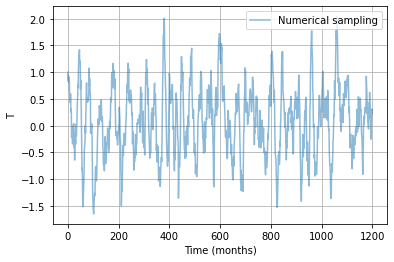

In [5]:
# Example 3-1. Solve RO with default settings
T_ro, h_ro, _ = RO_solver(par, IC, N, NE)   

time_axis = np.arange(0, N, saveat)
num_en = 0 # plot first ensemble member solution of T

plt.figure()
plt.plot(time_axis, T_ro[:, num_en],  label='Numerical sampling',  alpha=0.5)
plt.xlabel("Time (months)")
plt.ylabel("T")
plt.legend()
plt.grid()
plt.show()

### Advanced Usage

**`T_ro, h_ro, _ = RO_solver(par, IC, N, NE, NM)`**

**`T_ro, h_ro, _ = RO_solver(par, IC, N, NE, NM, dt)`**                      

**`T_ro, h_ro, _ = RO_solver(par, IC, N, NE, NM, dt, saveat)`**              

**`T_ro, h_ro, _ = RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod)`**  

**`T_ro, h_ro, _ = RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod, EF)`**                             

**`T_ro, h_ro, _ = RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod, EF, noise_custom)`**               

- Optional arguments allow for more control.

- Each additional argument gives more precise control over the solver. 

- Refer to the previous section for details on each argument.

---------------------------------------------------------------------------------
Welcome to the CRO Solver! Your simulation setup is as follows:
---------------------------------------------------------------------------------
 - Total simulation length: N = 1200 months
 - Number of ensemble members: NE = 2
 - Numerical integration time step: dt = 0.1 months (default: 0.1)
 - Data output interval: saveat = 1.0 months (default: 1.0)
 - Initial conditions: IC = [T0, h0] = [1.0, 0.0]
 - Input parameters have the expected shapes.
 - 'n_T' = 1: White noise forcing in the T equation; 'm_T' is ignored.
 - 'n_h' = 1: White noise forcing in the h equation; 'm_h' is ignored.
 - 'n_g' = 2: Additive noise is used in the T equation; 'B' is ignored.
 - Numerical integration method: NM = 'EH' (Euler–Heun method; default)
 - Data saving method: savemethod = sampling (default)
 - External forcing is not given, therefore using
   EF = {'E_T': [0.0, 0.0, 0.0, 0.0, 0.0], 'E_h': [0.0, 0.0, 0.0, 0.0, 0.0]}

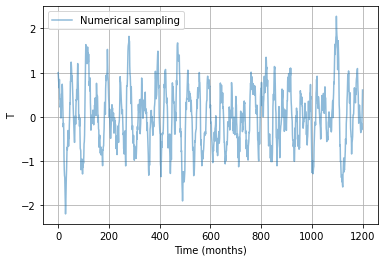

In [6]:
# Example 3-2. Solve RO with user-specified settings
T_ro, h_ro, _ = RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod, EF, noise_custom)     

time_axis = np.arange(0, N, saveat)
num_en = 0 # plot first ensemble member solution of T

plt.figure()
plt.plot(time_axis, T_ro[:, num_en],  label='Numerical sampling',  alpha=0.5)
plt.xlabel("Time (months)")
plt.ylabel("T")
plt.legend()
plt.grid()
plt.show()

### Analytical Solutions																			  

**`T_ref, h_ref, _ = RO_solver_analytic(par, IC, N, NE)`**

**`T_ref, h_ref, _ = RO_solver_analytic(par, IC, N, NE, dt)`**               

**`T_ref, h_ref, _ = RO_solver_analytic(par, IC, N, NE, dt, saveat)`**       

**`T_ref, h_ref, _ = RO_solver_analytic(par, IC, N, NE, dt, saveat, savemethod)`**                       

**`T_ref, h_ref, _ = RO_solver_analytic(par, IC, N, NE, dt, saveat, savemethod, noise_custom)`**  

- This function returns the **analytical solution** for the **linear RO system** without seasonality, using **white additive noise**.  
  Its usage is structurally similar to `RO_solver`, but with the following key differences: `'NM'` (numerical method) and `'EF'` (external forcing) are **not required or accepted**.

- To ensure a **meaningful comparison** with the numerical solution from `RO_solver`, use the **same seed** for `noise_custom` in both simulations.

---------------------------------------------------------------------------------
Welcome to the CRO Solver! Your simulation setup is as follows:
---------------------------------------------------------------------------------
 - Total simulation length: N = 1200 months
 - Number of ensemble members: NE = 2
 - Numerical integration time step: dt = 0.1 months (default: 0.1)
 - Data output interval: saveat = 1.0 months (default: 1.0)
 - Initial conditions: IC = [T0, h0] = [1.0, 0.0]
 - Input parameters have the expected shapes.
 - 'n_T' = 1: White noise forcing in the T equation; 'm_T' is ignored.
 - 'n_h' = 1: White noise forcing in the h equation; 'm_h' is ignored.
 - 'n_g' = 2: Additive noise is used in the T equation; 'B' is ignored.
 - Numerical integration method: NM = 'EH' (Euler–Heun method; default)
 - Data saving method: savemethod = sampling (default)
 - External forcing is not given, therefore using
   EF = {'E_T': [0.0, 0.0, 0.0, 0.0, 0.0], 'E_h': [0.0, 0.0, 0.0, 0.0, 0.0]}

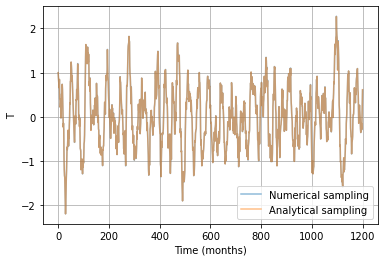

In [7]:
# Example 3-3. Compare numerical and analyticla solution
T_ro, h_ro, _ = RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod, EF, noise_custom)  
T_ref, h_ref, _ = RO_solver_analytic(par, IC, N, NE, dt, saveat, savemethod, noise_custom)

time_axis = np.arange(0, N, saveat)
num_en = 0 # plot first ensemble member solution of T

plt.figure()
plt.plot(time_axis, T_ro[:, num_en],  label='Numerical sampling',  alpha=0.5)
plt.plot(time_axis, T_ref[:, num_en], label='Analytical sampling', alpha=0.5)
plt.xlabel("Time (months)")
plt.ylabel("T")
plt.legend()
plt.grid()
plt.show()

**`RO_std_analytic(par)`**

- It returns the **theoretical standard deviations** for the **linear-white-additive** configuration based on the given parameter dictionary `par`.

**`BWJ = RO_BWJ(par)`**

- It computes the expected **BJ** and **Wyrtki** indices, where the real part (`{BWJ.real}`) corresponds to the BJ index and the imaginary part (`{BWJ.imag}`) corresponds to the Wyrtki index, based on the given parameter dictionary `par`.
																			  

In [8]:
# Example 3-4. Compare standard deviation of numerical and analytial solutions
T_ref_std, h_ref_std = RO_std_analytic(par) # calculate theoretical standard deviations

T_ro, h_ro, _ = RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod, noise_custom=None)
T_ro_std = np.std(T_ro, axis=0); h_ro_std = np.std(h_ro, axis=0)
T_ro_std_mean = np.mean(T_ro_std); h_ro_std_mean = np.mean(h_ro_std) # ensemble mean

print("Standard drviations for T (analytical):")
print(T_ref_std)
print("Standard drviations for T (ensemble mean for numerical solutions):")
print(T_ro_std_mean)
print("Standard drviations for h (analytical):")
print(h_ref_std)
print("Standard drviations for h (ensemble mean for numerical solutions):")
print(h_ro_std_mean)


# Example 3-5. Calculate BWJ Index
BWJ = RO_BWJ(par)
print(f"BJ index: {BWJ.real} [1/month]")
print(f"Wyrtki index: {BWJ.imag:.3f} [1/month]. "
      f"This corresponds to a periodicity of {2*np.pi/BWJ.imag:.3f} months.")

---------------------------------------------------------------------------------
Welcome to the CRO Solver! Your simulation setup is as follows:
---------------------------------------------------------------------------------
 - Total simulation length: N = 1200 months
 - Number of ensemble members: NE = 2
 - Numerical integration time step: dt = 0.1 months (default: 0.1)
 - Data output interval: saveat = 1.0 months (default: 1.0)
 - Initial conditions: IC = [T0, h0] = [1.0, 0.0]
 - Input parameters have the expected shapes.
 - 'n_T' = 1: White noise forcing in the T equation; 'm_T' is ignored.
 - 'n_h' = 1: White noise forcing in the h equation; 'm_h' is ignored.
 - 'n_g' = 2: Additive noise is used in the T equation; 'B' is ignored.
 - Numerical integration method: NM = 'EH' (Euler–Heun method; default)
 - Data saving method: savemethod = sampling (default)
 - External forcing is not given, therefore using
   EF = {'E_T': [0.0, 0.0, 0.0, 0.0, 0.0], 'E_h': [0.0, 0.0, 0.0, 0.0, 0.0]}

## 4. RO Parameter Fitting Setup

### Input T and h Time Series

- T and h are input timeseries used for the fitting.

- T and h must be 1D time series arrays with a uniform time step. 

### Specifiying RO Type

- These options define the RO model type used for fitting.

- par_option_T specifies the linear and nonlinear terms in dT/dt

- par_option_h specifies the linear and nonlinear terms in dh/dt

- The following example shows how to set the RO type as linear-white-additive RO for the fitting.

In [9]:
par_option_T = {"R": 1, "F1": 1, "b_T": 0, "c_T": 0, "d_T": 0}
par_option_h = {"F2": 1, "epsilon": 1, "b_h": 0}

- For keys in `par_option_T` and `par_option_h`, allowed values are:
  - `0` — Do not estimate
  - `1` — Estimate only the annual mean
  - `3` — Estimate annual mean + annual seasonality
  - `5` — Estimate annual mean + annual + semi-annual seasonality    

- par_option_noise specifies the noise type

In [10]:
par_option_noise = {"T": "white", "h": "white", "T_type": "multiplicative"}

- Valid options for $T$ and $h$ are: 
    - `"white"`: white noise forcing
    - `"red"`: red noise forcing
- Both $T$ and $h$ **must use the same noise type**; otherwise, an error is raised.
- Valid options for `T-type` (noise structure for $T$) are:  
    - `"additive"`: T noise forcing is additive
    - `"multiplicative"`: T noise forcing is multiplicative
    - `"multiplicative-H"`: T noise forcing is Heaviside based-multiplicative noise

### Advanced Usage (optional)

- The following block sets additional **optional settings** for the RO parameter fitting.
- The user may skip specifying these options. If the user doesn't specify these options, the RO parameter
fitting runs with the default settings.
- method_fitting specifies the parameter fitting method:
    - `"LR-F"`: Linear regression (tendency with forward differencing scheme) 
    - `"LR-C"`: Linear regression (tendency with central differencing scheme)
    - `"LR-F-MAC"`: Linear regression (tendency with forward differencing scheme) with Moments Analytical Constraints estimation for T noise parameters 
    - `"MLE"`: Maximum Likelihood Estimation (tendency with forward differencing scheme)
- dt specifies time interval of input T and h time series in month (default = 1.0).
- The default method depends on the specified RO type, as indicated in `"table_default_fitting_method.txt"`.
- Details of the fitting methods are documented in the manual and the accompanying paper.

In [11]:
method_fitting="MLE"
dt = 1.0

## 5. RO Parameter Fitting from Time Series

### Basic Usage

**`par_fitted = RO_fitting(T, h, par_option_T, par_option_h, par_option_noise)`**

- `par_fitted` has the same format as `par` in the section 2. 

In [12]:
# Example 5-1. RO parameter fitting with default settings
# using simulated T and h.
T_ro, h_ro, _ = RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod, EF, noise_custom)
num_en = 0

par_option_T = {"R": 1, "F1": 1, "b_T": 0, "c_T": 0, "d_T": 0}
par_option_h = {"F2": 1, "epsilon": 1, "b_h": 0}
par_option_noise = {"T": "white", "h": "white", "T_type": "additive"}

par_fitted = RO_fitting(T_ro[:,num_en], h_ro[:,num_en], par_option_T, par_option_h, par_option_noise)

print("The fitting results are:")
print(par_fitted)

---------------------------------------------------------------------------------
Welcome to the CRO Solver! Your simulation setup is as follows:
---------------------------------------------------------------------------------
 - Total simulation length: N = 1200 months
 - Number of ensemble members: NE = 2
 - Numerical integration time step: dt = 1.0 months (default: 0.1)
 - Data output interval: saveat = 1.0 months (default: 1.0)
 - Initial conditions: IC = [T0, h0] = [1.0, 0.0]
 - Input parameters have the expected shapes.
 - 'n_T' = 1: White noise forcing in the T equation; 'm_T' is ignored.
 - 'n_h' = 1: White noise forcing in the h equation; 'm_h' is ignored.
 - 'n_g' = 2: Additive noise is used in the T equation; 'B' is ignored.
 - Numerical integration method: NM = 'EH' (Euler–Heun method; default)
 - Data saving method: savemethod = sampling (default)
 - External forcing is not given, therefore using
   EF = {'E_T': [0.0, 0.0, 0.0, 0.0, 0.0], 'E_h': [0.0, 0.0, 0.0, 0.0, 0.0]}

### Advanced Usage

**`par_fitted = RO_fitting(T, h, par_option_T, par_option_h, par_option_noise, method_fitting)`**  

**`par_fitted = RO_fitting(T, h, par_option_T, par_option_h, par_option_noise, method_fitting, dt)`**

In [13]:
# Example 5-2. RO parameter fitting with user-specified settings
# using simulated T and h
T_ro, h_ro, _ = RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod, EF, noise_custom)
num_en = 0

par_option_T = {"R": 1, "F1": 1, "b_T": 0, "c_T": 0, "d_T": 0}
par_option_h = {"F2": 1, "epsilon": 1, "b_h": 0}
par_option_noise = {"T": "white", "h": "white", "T_type": "additive"}

par_fitted = RO_fitting(T_ro[:,num_en], h_ro[:,num_en], par_option_T, par_option_h, par_option_noise, method_fitting, dt)

print("The fitting results are:")
print(par_fitted)


---------------------------------------------------------------------------------
Welcome to the CRO Solver! Your simulation setup is as follows:
---------------------------------------------------------------------------------
 - Total simulation length: N = 1200 months
 - Number of ensemble members: NE = 2
 - Numerical integration time step: dt = 1.0 months (default: 0.1)
 - Data output interval: saveat = 1.0 months (default: 1.0)
 - Initial conditions: IC = [T0, h0] = [1.0, 0.0]
 - Input parameters have the expected shapes.
 - 'n_T' = 1: White noise forcing in the T equation; 'm_T' is ignored.
 - 'n_h' = 1: White noise forcing in the h equation; 'm_h' is ignored.
 - 'n_g' = 2: Additive noise is used in the T equation; 'B' is ignored.
 - Numerical integration method: NM = 'EH' (Euler–Heun method; default)
 - Data saving method: savemethod = sampling (default)
 - External forcing is not given, therefore using
   EF = {'E_T': [0.0, 0.0, 0.0, 0.0, 0.0], 'E_h': [0.0, 0.0, 0.0, 0.0, 0.0]}

TypeError: 'sort_dicts' is an invalid keyword argument for print()

## 6. RO Parameter Fitting from Observations and Reproducing

In [ ]:
# load observations
fpath = os.path.join(os.getcwd(), "Data", "XRO_indices_oras5.nc")
nc_oras5 = Dataset(fpath, mode='r')
T_oras5 = nc_oras5.variables['Nino34'][:]  # Nino 3.4 since 1979-01-01
h_oras5 = nc_oras5.variables['WWV'][:]     # WWV since 1979-01-01
time_oras5 = nc_oras5.variables['time'][:] # Days since 1979-01-01

In [ ]:
# setting fitting options and print the fitted parameters
par_option_T = {"R": 5, "F1": 5, "b_T": 0, "c_T": 0, "d_T": 0}
par_option_h = {"F2": 5, "epsilon": 5, "b_h": 0}
par_option_noise = {"T": "red", "h": "red", "T_type": "additive"}

par_fitted_obs = RO_fitting(T_oras5, h_oras5, par_option_T, par_option_h, par_option_noise)
print(par_fitted_obs, sort_dicts=False)

**`func_mon_std(T)`** returns the **monthly standard deviations** of the input time series `T`, calculated separately for each calendar month from **January to December**.

- Be aware that the reproducibility of monthly standard deviations can vary depending on the RO type specified by the user.

In [ ]:
# RO simulations using the fitted parameters
T_ro_obs_based, h_ro_obs_based, _ = RO_solver(par_fitted_obs, IC, N, NE, NM, dt, saveat, savemethod, EF, noise_custom)
num_en = 0
time_axis_ro = np.arange(0, N, saveat)

# compare observationanal and RO time series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax1.plot(time_oras5 / 30, T_oras5, label='Obs.', alpha=0.5)
ax1.set_ylabel("T")
ax1.legend()
ax1.set_xlim(0,550)
ax1.set_ylim(-3,3)
ax1.grid(True)

ax2.plot(time_axis_ro, T_ro_obs_based[:, num_en], label='RO', alpha=0.5)
ax2.set_xlabel("Time (months)")
ax2.set_ylabel("T")
ax2.legend()
ax2.set_xlim(0,550)
ax2.set_ylim(-3,3)
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# compare monthly standard deviations
monthly_std_obs = func_mon_std(T_oras5)
monthly_std_ro = func_mon_std(T_ro_obs_based[:, num_en])
months = list(calendar.month_abbr[1:])  # ['Jan', 'Feb', ..., 'Dec']

plt.figure(figsize=(10, 5))
plt.plot(months, monthly_std_obs, marker='o', linewidth=2, label="Obs.")
plt.plot(months, monthly_std_ro, marker='o', linewidth=2, label="RO")
plt.title("Monthly Standard Deviation (Jan–Dec)")
plt.xlabel("Month")
plt.ylabel("Standard Deviation")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
nc_oras5.close()

## 7. Load RO Parameters from the Library & Solve

You can load pre-fitted RO parameters from the CRO parameter library. 
The library includes parameters estimated from observations and from 48
CMIP6 historical simulations, for multiple RO types.

### Usage
**`par = RO_solver(data_name, RO_type)`**

- **`data_name`**: data source for the parameter set.
  - Options include the observational dataset **`ORAS5`** and **`CMIP6-historical-1`** … **`CMIP6-historical-48`**.
  - Use **`CMIP6-historical-all`** to load all available CMIP6 members (shape `(48, 16)`).

- **`RO_type`**: the RO equation type used in the parameter fitting (see CRO manual for the full list).

- See the CRO manual for complete option lists and definitions.

- The example below shows how to load parameter values for a Linear-White-Additive type RO equation. 

In [ ]:
# Example 7-1. ORAS5 reanalysis (1958-2022) 
data_name = "ORAS5" 
RO_type = "Linear-White-Additive"
par = par_load(data_name,RO_type)

In [ ]:
# Example 7-2. CMIP6 CESM2 historial simulation (ensemble number 8) 
data_name = "CMIP6-historical-8" 
RO_type = "Linear-White-Additive"
par = par_load(data_name,RO_type)

In [ ]:
# Example 7-3. All 48 CMIP6 historial simulations in the libarary 
# In this case, par.shape == (48, 16), i.e. 48 rows of parameter sets.
# Use par[i] (0 ≤ i < 48) to extract parameters from the ensemble member of your choice.
# Be careful with indexing: i = 0..(47) extract CMIP6-historical-1..(48). 
data_name = "CMIP6-historical-all"
RO_type = "Linear-White-Additive"
par = par_load(data_name,RO_type)

### Applications

- Using the parameter library, users can quickly set up parameters for solving the CRO model.  

- The example below shows how to load the parameter set fitted for the **CMIP6 CESM2 historical simulation** with the **Seasonal–Linear–White–Additive** RO type, and then solve it.


In [ ]:
# Example 7-4. Solving RO using CMIP6 historical CESM2 parameter
data_name = "CMIP6-historical-8"; 
RO_type = "Seasonal-Linear-White-Additive"
par = par_load(data_name, RO_type)

IC = [1.0, 0.0] # % Initial conditions for T (K) and h (m) 
N = 12*100;    # Simulation length (month)
NE = 2          # Number of ensemble members 


T_CESM2_en, h_CESM2_en, _ = RO_solver(par, IC, N, NE)
num_en = 0

time_axis_ro = np.arange(0, N)
plt.plot(time_axis_ro, T_CESM2_en[:,num_en]) 
plt.xlabel("Time (months)")
plt.ylabel("T (K)")